# Assignment 1

**Authors**: Vincenzo Collura, Gianmarco Pappacoda, Anthea Silvia Sasdelli

Part-of Speech (POS) tagging as Sequence Labelling using Recurrent Neural Architectures. Given a corpus of documents, predict the POS tag for each word.

## Dependencies

In [1]:
# Imported libraries
import numpy as np
import pandas as pd
import warnings
import random
import copy
from tqdm import tqdm
from typing import List, Union
from collections import OrderedDict

# Plotting libraries
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# File handling
import os
import urllib
import zipfile
from io import StringIO
from pathlib import Path

# Glove embeddings
import gensim
import gensim.downloader as gloader

# DL libraries
import tensorflow as tf
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support as prfs
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

warnings.filterwarnings('ignore')
pd.options.plotting.backend = "plotly"

In [2]:
# paths
data_path = 'data/'
if not os.path.exists(data_path):
    os.makedirs(data_path)

models_path = 'models/'
if not os.path.exists(models_path):
    os.makedirs(models_path)

In [3]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_reproducibility(42)

## Data retrieval & loading

### Data download

In the following cells the download of the [Penn Treebank](https://catalog.ldc.upenn.edu/docs/LDC95T7/cl93.html) dataset and [GloVe](https://nlp.stanford.edu/projects/glove/) is performed. Furthermore, it is possible to set the GloVe embedding size through the **EMBEDDING_SIZE** constant.

In [4]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)
        
def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

In [5]:
def download_file(url, path, extract_path=None, extract=True, skip_if_exists=True):
    """
    download file

    Parameters
    ----------
    url : string
        url of the file you want to save.
    path : string
        path where you want to save the file you are downloading.
    extract : bool, default True
        set it to True if you want to extract your file, False otherwise.
    skip_if_exists : bool, default True
        set it to True if you want to skip the download if the file already exist, False otherwise.
    """
    path = Path(path)
    if path.is_file() and skip_if_exists:
        print("File present, skiping...")
        return
    
    file_name = url.split('/')[-1]

    print(f"Downloading {file_name}... (it may take a while)")
    
    download_url(url=url, output_path=path)

    if extract and extract_path != None:
        os.makedirs(extract_path, exist_ok=True)
        print(f"Extracting {file_name} in {data_path}")
        with zipfile.ZipFile(path, 'r') as zip_file:
            zip_file.extractall(extract_path)

In [6]:
# Download dataset
download_file('https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip', os.path.join(data_path, 'treebank.zip'), os.path.join(data_path, 'treebank'))

File present, skiping...


In [7]:
# Download data embedding
download_file('http://nlp.stanford.edu/data/glove.6B.zip', os.path.join(data_path, 'glove.6B.zip'), os.path.join(data_path, 'glove'))

File present, skiping...


In [8]:
# set dimension of the embedding
EMBEDDING_SIZE = 100

# load pre-trained glove vectors
download_path = f"glove-wiki-gigaword-{EMBEDDING_SIZE}"
word2vec = gloader.load(download_path)

### Data preparation

In the following cells the documents are processed to be stored in a dataframe. Each token/pos tuple is then associated with its respective document and phrase. In order to differentiate each phrase across all documents, each phrase is assigned with an incremental identification number.

Secondly, three sets (training, validation, test) are created starting from the original dataset. 

Documents 1-100 are assigned to training set, 101-150 to validation set, 151-199 to test set.

In [9]:
# Train      doc # 1-100
# Validation doc # 101-150
# Test       doc # 151-199
splits = [slice(0, 100), slice(100, 150), slice(150, 199)]

files =  [f for f in Path(data_path + 'treebank/dependency_treebank').iterdir() if f.is_file()]

dfs = {
    'train': pd.DataFrame(),
    'val': pd.DataFrame(),
    'test': pd.DataFrame()
}

# The files are read and split as described above, a document_id and phrase_id is attached,
# the third value (dependency) is discarded
phrase_id = 0
for name, split in zip(dfs, splits):
    for file in files[split]:
        with open(file, 'r') as f:
            sentences = f.read()
            if sentences.find('\n\n') != -1:
                sentences = sentences.split('\n\n')
                for sentence in sentences:
                    phrase_id += 1
                    string = StringIO(sentence)
                    temp_df = pd.read_csv(string, sep='\t', header=None)
                    temp_df['document_id'] = file.stem.split('_')[1]
                    temp_df['phrase_id'] = phrase_id
                    dfs[name] = pd.concat([dfs[name], temp_df], ignore_index=1)
                    
            else:
                phrase_id += 1
                temp_df = pd.read_csv(file, sep='\t', header=None)
                temp_df['document_id'] = file.stem.split('_')[1]
                temp_df['phrase_id'] = phrase_id
                dfs[name] = pd.concat([dfs[name], temp_df], ignore_index=1)
                

for key in dfs.keys():
    dfs[key].drop(2, axis=1, inplace=True) # ignore the numeric value
    dfs[key].columns = ['token', 'pos', 'document_id', 'phrase_id']

# create train, validation and test df
df_train = dfs['train']
df_test = dfs['test']
df_val = dfs['val']

Here's a glance of the training dataframe structure:

In [10]:
df_train.head()

,token,pos,document_id,phrase_id
0,Pierre,NNP,0001,1
1,Vinken,NNP,0001,1
2,",",",",0001,1
3,61,CD,0001,1
4,years,NNS,0001,1


Set the variable 'split' to 'phrase_id' to use sentence splitting, set the variable 'split' to 'document_id' to use document splitting.

In [11]:
SPLIT_METHOD = 'phrase_id'

assert(SPLIT_METHOD == 'phrase_id' or SPLIT_METHOD == 'document_id')

## Explanatory Data Analysis

### Sequence Length


Check distrubition of the lenghts in the training and validation set to find a good max sequence lenght.

In [12]:
counts = pd.concat([
    df_train.groupby(SPLIT_METHOD).size(),
    df_val.groupby(SPLIT_METHOD).size()
], keys=["Training", "Validation"], axis=1)

In [13]:
fig = px.histogram(
    counts,
    title='Distribution of sentences length in the training/validation set',
    barmode='overlay',
    histnorm='percent',
    labels={
        "variable": "Set"
    }
)
cut = np.ceil(np.percentile(df_train.groupby(SPLIT_METHOD).size().to_list(), 99))
fig.add_vline(x=cut + 0.5, line_width=1, line_color="red")
fig.update_layout(yaxis_title="Number of samples (%)", xaxis_title="Length")
fig.show()

The distribution of sentences length in training and validation sets are, as hypothesized, comparable. This ensures the validation set is employable to perform validation during training. Moreover, it is possible to cut the sequences in order to reduced the computational power needed to perform both training and inference. In order to perform the cut, the 99th percentile of the lengths has been selected. Needless to say, were the distribution of the documents sentences to change, the maximum allowed sentence length would have to be adjusted accordingly.

In [14]:
MAX_SEQ_LENGTH = int(cut)
print('Max sequence length: ' + str(MAX_SEQ_LENGTH))

Max sequence length: 56


### POS tags distribution

Let's now take a look at the distribution of the classes.

In [15]:
# Created 
tag_counts = pd.concat(
    [
        df_train['pos'].value_counts(),
        df_val['pos'].value_counts()
    ],
    keys=["Training", "Validation"],
    axis=1
).reset_index()
tag_counts = pd.melt(tag_counts, id_vars='index')

In [16]:
fig = px.histogram(
    tag_counts,
    x='index',
    y='value',
    color='variable',
    title='Distribution of POS tags in training and validation sets',
    barmode='group',
    histnorm='percent',
    labels={
        "variable": "Set"
    },
    color_discrete_sequence=[
        'indianred',
        'lightsalmon'
    ]
)
fig.update_layout(yaxis_title="Number of samples (%)", xaxis_title="POS tag", xaxis_tickangle=-45,)
fig.show()

The dataset is unbalanced with respect to the classes, as to be expected nouns are the most prominent entries.

### OOV terms checking

Since GloVe pre-trained embeddings will be used to perform term embedding it is worth to check how many Out-Of-Vocabulary (OOV) terms are present in the data set. Notice the check is performed on training set only as OOVs are expected to appear at any time in any set. This is also due to the fact the authors are not allowed to train new embeddings or use "dynamic" (i.e. non-static) ones.

In [17]:
train_vocab = df_train['token'].explode().drop_duplicates().to_list()
embedding_vocabulary = set(word2vec.index_to_key)
oovs = list(set(df_train['token']).difference(embedding_vocabulary))

print('OOV in the training set: ', len(oovs))

OOV in the training set:  2346


In [18]:
TRUNCATION = 100

oov_occurrence = df_train['token'].explode()[df_train['token'].explode().isin(oovs)]
oov_occurrence = oov_occurrence.value_counts()[:TRUNCATION]

fig = go.Figure()
fig.add_trace(go.Bar(
    x=oov_occurrence.keys(),
    y=oov_occurrence.values,
    name='OOV counts',
    marker_color='indianred'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45, title = f"First {TRUNCATION} OOVs (with capital letter) and their counts")
fig.show()

One of the most striking observations is that very common words such as "The" or "In" are not in the vocabulary. This is due to the fact they have a capital letter whilst GloVe embedding use lower-case only words. It is therefore important to transform all the words in lower-case when performing this analysis.

In [19]:
def get_OOV(embedding_model: gensim.models.keyedvectors.KeyedVectors, word_listing):
    """
    find and list OOV words lowercasing each word

    Parameters
    ----------
    embedding_model : gensim.models.keyedvectors.KeyedVectors
         embedding model
    word_listing : pandas series
        column of token of a pandas dataframe
    """
    embedding_vocabulary = set(embedding_model.index_to_key)
    low = list(map(lambda x: x.lower(), word_listing))
    oovs = list(set(low).difference(embedding_vocabulary))

    return oovs

oov_train = get_OOV(word2vec, df_train['token'])
print('OOV in the training set: ', len(oov_train))

OOV in the training set:  359


In [20]:
TRUNCATION = 100

oov_train = get_OOV(word2vec, df_train['token'])
oov_occurrence = df_train['token'].explode()[df_train['token'].explode().isin(oov_train)]
oov_occurrence = oov_occurrence.value_counts()[:TRUNCATION]

fig = go.Figure()
fig.add_trace(go.Bar(
    x=oov_occurrence.keys(),
    y=oov_occurrence.values,
    name='OOV counts',
    marker_color='indianred'
))

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode='group', xaxis_tickangle=-45, title = f"First {TRUNCATION} OOVs (lower-case) and their counts")
fig.show()

Once again it is interesting to notice that most OOVs are "dashed words": composed of two words interleaved by a dash "-". Secondly, slashes "/" are "escaped" into "\/". Thirdly there are fractions (e.g. 3/4) and real numbers.

### Data processing

In the following cells dataframes used for EDA are converted to sequences of strings in order to better process them. As there is no requirement to perform preprocessing, the only form of preprocessing that will be applied is transforming the sentences to lower-case.

In [21]:
def df_to_xy(df: pd.DataFrame, token_name='token', pos_name='pos', document_id='document_id', phrase_id='phrase_id', split_phrases=True):
    """
    from df to X and y.

    Parameters
    ----------
    df : object
        pandas df.
    token_name : string, default 'token'
       token column header.
    pos_name : string, default 'pos'
        part-of-speech tagging column header.
    document_id : string, default 'document_id'
        document id column header.
    phrase_id : string, default 'phrase_id'
        phrase id column header.
    split_phrases : bool, default True
        set it to True if you want to use sentence splitting, False to use document splitting

    Returns
    -------
    X_train.to_list(), y_train.to_list() : list
        X train and y train.
    """
    if split_phrases:
        split = phrase_id
    else:
        split = document_id
    X_train = df.groupby(split)[token_name].agg(list)
    y_train = df.groupby(split)[pos_name].agg(list)

    return X_train.to_list(), y_train.to_list()

Split train, val and test into X and y

In [22]:
X_train_raw, y_train_raw = df_to_xy(df_train, split_phrases = True if SPLIT_METHOD == 'phrase_id' else False)
X_val_raw, y_val_raw = df_to_xy(df_val, split_phrases = True if SPLIT_METHOD == 'phrase_id' else False)
X_test_raw, y_test_raw = df_to_xy(df_test, split_phrases = True if SPLIT_METHOD == 'phrase_id' else False)

#### Lowercase

In [23]:
X_train_raw = [[word.lower() for word in sequence] for sequence in X_train_raw]
X_val_raw = [[word.lower() for word in sequence] for sequence in X_val_raw]
X_test_raw = [[word.lower() for word in sequence] for sequence in X_test_raw]

### Building Vocabulary

In [24]:
class Vocabulary:
    """ Stores a vocabulary for NLP tasks
    """

    def __init__(self, word2idx=OrderedDict(), idx2word=OrderedDict(), curr_idx=2, oov_index=1, oov_token='-OOV-'):
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.curr_idx = curr_idx  # 0-1 reserved
        self.oov_index = 1
        self.oov_token = oov_token
    
    def import_gensim(self, embedding_model: gensim.models.keyedvectors.KeyedVectors) -> None:
        """ Import an existing vocabulary from a gensim model

        Parameters
        ----------
        embedding_model : gensim.models.keyedvectors.KeyedVectors
            Embedding model
        """
        self.idx2word.update(OrderedDict(enumerate(embedding_model.index_to_key, 2))) # strat from 1 as 0 is reserved
        self.word2idx = {v: k for k, v in self.idx2word.items()}
        self.curr_idx = len(self.idx2word) + 2
    
    def build_from_list(self, sentences: List[List[str]]) -> None:
        """ Adds words to vocabulary starting from a list of documents

        Parameters
        ----------
        sentences : List[List[str]]
            Expected format: [document][sentence][token]
        """
        for sentence in tqdm(sentences):
            for token in sentence:
                if token not in self.word2idx:
                    self.word2idx[token] = self.curr_idx
                    self.idx2word[self.curr_idx] = token
                    self.curr_idx += 1
    
    def encode(self, sentences: List[List[str]]) -> List[List[int]]:
        """ Encode a sequence

        Parameters
        ----------
        sentences : List[List[str]]
            Expected format: [document][sentence][token]

        Returns
        -------
        List[List[int]]
            Return format: [document][sentence][encoded_token]
        """
        encoded = [[self.word2idx[token] if token in self.word2idx.keys() else self.oov_index for token in sentence] for sentence in sentences]
 
        return encoded

    def decode(self, sentences: List[List[int]]) -> List[List[str]]:
        """ Decode a sequence

        Parameters
        ----------
        sentences : List[List[int]]
            Expected format: [document][sentence][encoded_token]

        Returns
        -------
        List[List[str]]
            Return format: [document][sentence][token]
        """
        decoded = [[self.idx2word[encoded_id] if encoded_id in self.idx2words.keys() else self.oov_token for encoded_id in sentence] for sentence in sentences]
    
        return decoded
    
    def get_OOV(self, sentences: List[List[str]]):
        """ Find and list OOV words

        Parameters
        ----------
        embedding_model : gensim.models.keyedvectors.KeyedVectors
            embedding model
        sentences : pandas series
            column of token of a pandas dataframe
        """
        ret = [item for sublist in sentences for item in sublist]
        oovs = list(set(ret).difference(self.idx2word.values()))

        return oovs
    
    
    def copy(self):
        """ Returns a (deep) copy of itself

        Returns
        -------
        Vocabulary
            Deep copy of instance
        """
        return copy.deepcopy(self)

In [25]:
voc_glove = Vocabulary()
voc_glove.import_gensim(word2vec)
oov1 = voc_glove.get_OOV(X_train_raw)

voc_train = voc_glove.copy()
voc_train.build_from_list(X_train_raw)

100%|██████████| 1963/1963 [00:00<00:00, 260798.82it/s]


Quick look ino training set statistics

In [26]:
num_tags  = len(set([word.lower() for sentence in y_train_raw for word in sentence]))

print("TRAIN statistics")
print(f"Number of documents: {len(df_train.groupby('document_id').count())}")
print(f"Total number of sentences: {len(X_train_raw)}")
print(f"Vocabulary size: {len(voc_train.idx2word)}")
print(f"OOVs: {len(oov1)}")
print(f"Total number of tags: {num_tags}")
print(f'Some words: {list(voc_train.idx2word.items())[:10]}')

TRAIN statistics
Number of documents: 100
Total number of sentences: 1963
Vocabulary size: 400359
OOVs: 359
Total number of tags: 45
Some words: [(2, 'the'), (3, ','), (4, '.'), (5, 'of'), (6, 'to'), (7, 'and'), (8, 'in'), (9, 'a'), (10, '"'), (11, "'s")]


In [27]:
oov2 = voc_train.get_OOV(X_val_raw)
voc_val = voc_train.copy()
voc_val.build_from_list(X_val_raw)

oov3 = voc_train.get_OOV(X_test_raw)
voc_test = voc_train.copy()
voc_test.build_from_list(X_test_raw)

100%|██████████| 652/652 [00:00<00:00, 260570.39it/s]


In [28]:
print(f"OOVs (validation): {len(oov2)}")
print(f"OOVs (test): {len(oov3)}")

OOVs (validation): 189
OOVs (test): 140


### Tokenization

In the following section the sequences are tokenized. While the text sequences can leverage the vocabulary built above, the pos sequences will instead use a tokenizer utility class to perform label encoding.

In [29]:
# text to sequences
X_train_enc = voc_train.encode(X_train_raw)
X_val_enc = voc_val.encode(X_val_raw)
X_test_enc = voc_test.encode(X_test_raw)

In [30]:
# instantiation text tokenization utility class
tag_tokenizer = Tokenizer()

# updates internal vocabulary based on X train + test + val raw
tag_tokenizer.fit_on_texts(y_train_raw + y_test_raw + y_val_raw)

# text to sequences
y_train_enc = tag_tokenizer.texts_to_sequences(y_train_raw)
y_val_enc = tag_tokenizer.texts_to_sequences(y_val_raw)
y_test_enc = tag_tokenizer.texts_to_sequences(y_test_raw)

Look at first encoded data point

In [31]:
# look at first encoded data point
print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X_train_raw[0], '\n')
print('Y: ', y_train_raw[0], '\n')
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_train_enc[0], '\n')
print('Y: ', y_train_enc[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', '29', '.'] 

Y:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.'] 

** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [5031, 400002, 3, 4980, 84, 169, 3, 45, 1431, 2, 536, 21, 9, 128566, 371, 2345, 1265, 4] 

Y:  [3, 3, 7, 9, 5, 6, 7, 20, 12, 4, 1, 2, 4, 6, 1, 3, 9, 8] 



### Truncation & Padding

In order to feed the input to the models it is important to render all the sequences to the same length. In this step sequences exceeding the maximum allowed sequence length are truncated, sequences that are shorter than it are "padded" with zeros.

In [32]:
# pad X train, val and test
X_train_padded = pad_sequences(X_train_enc, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_enc, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_enc, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")

X_train, X_val, X_test = X_train_padded, X_val_padded, X_test_padded

# pad y train, val and test
y_train_padded = pad_sequences(y_train_enc, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
y_val_padded = pad_sequences(y_val_enc, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
y_test_padded = pad_sequences(y_test_enc, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")

y_train, y_val, y_test = y_train_padded, y_val_padded, y_test_padded

print(f"Padding example:\n {X_train_padded[0]}")

Padding example:
 [  5031 400002      3   4980     84    169      3     45   1431      2
    536     21      9 128566    371   2345   1265      4      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0]


### One-Hot encoding (classes)

The chosen method to represent classes is the One-Hot encoding. In this representation each class has n (number of classes) dimensions, each vector representing a class i only has the i-th bit equal to 1 whilst all the other are set to 0. This representation is pretty useful as it prevents the model from interpreting the classes as part of a scale.

In [33]:
y = y_train.tolist() + y_val.tolist() + y_test.tolist()

# instantiate one hot encoder
oh = OneHotEncoder(sparse=False)
oh.fit(pd.melt(pd.DataFrame(y))['value'].to_numpy().reshape(-1, 1))

OneHotEncoder(sparse=False)

In [34]:
def one_hot_sequence(oh: OneHotEncoder, sequence: List) -> List:
    return np.apply_along_axis(lambda x: oh.transform(x.reshape(-1, 1)), 1, sequence)

def inverse_one_hot_sample(sample: List, oh: OneHotEncoder) -> int:
    return oh.inverse_transform(sample.reshape(1, -1))[0][0]

In [35]:
y_train = one_hot_sequence(oh, y_train)
y_val = one_hot_sequence(oh, y_val)
y_test = one_hot_sequence(oh, y_test)

print(f"One hot example: {y_train[0][0]}")

One hot example: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [36]:
NUM_CLASSES = y_train.shape[2]
print(f"Number of classes: {NUM_CLASSES}")

Number of classes: 46


## Models definition and training

In this section the models are defined and trained, the first part of the network (embedding layer) is common to all the other ones and since it is not trainable it can be shared among all the models and has been defined here. A custom f1-score implementation is also present in order to have a glance batch-wise of the metric.

### Custom F1-score

In [37]:
import keras.backend as K

# taken from old keras source code
def f1(y_true, y_pred):
    """ Compute f1-score, Keras/TF-friendly
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### Embedding layer

In [38]:
# assign word vectors from word2vec model

voc = voc_val

VOCABULARY_SIZE = len(voc.idx2word) + 2

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2idx = voc.word2idx

emb_voc = {}

# copy vectors from word2vec model to the words present in corpus
for word, index in word2idx.items(): #+ word2vec.key_to_index.keys():
    try:
        embedding_weights[index, :] = word2vec[word]
    except (KeyError, TypeError):
        if word not in emb_voc:
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=EMBEDDING_SIZE)
            emb_voc[word] = embedding_vector
        
        embedding_weights[index:] = emb_voc[word]

In [39]:
embedding_layer = Embedding(input_dim              = VOCABULARY_SIZE,
                            output_dim             = EMBEDDING_SIZE,
                            input_length           = MAX_SEQ_LENGTH,
                            embeddings_initializer = keras.initializers.Constant(embedding_weights),
                            mask_zero              = False,
                            trainable              = False)

### Hyperparameters, metrics, optimizer and callbacks

In [40]:
# Main parameters
num_epochs = 1000
batch_size = 256
learning_rate = 0.01

# Reduce LR parameters
patience = 15
min_lr = learning_rate/100
reduce_lr_factor = 0.5

# Early stopping
es_patience = 100

# Optimizer, loss, metrics, callbacks
optimizer = Nadam(learning_rate=learning_rate)
loss = tf.keras.losses.categorical_crossentropy
checkpoint_method = 'val_f1'
metrics = [
    "accuracy",
    f1
]

In [41]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=reduce_lr_factor, patience=patience, min_lr=min_lr),
    EarlyStopping(monitor="val_loss", patience=es_patience, min_delta=0.01),
]

In [42]:
def get_checkpoint_name(model):
    return f"models/{model.name}.h5"

In [43]:
def get_checkpoint(model):
    return ModelCheckpoint(
        filepath=get_checkpoint_name(model),
        save_weights_only=True,
        monitor=checkpoint_method,
        mode='max',
        save_best_only=True
    )

In [44]:
models = {}
history = {}

### Baseline

The baseline model is a simple Recurrent Neural Network using a Bidirectional LSTM layer followed by a softmax one.

In [45]:
model_name = 'baseline'
units = 100

In [46]:
int_sequences_input = keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(embedded_sequences)
x = layers.TimeDistributed(layers.Dense(NUM_CLASSES))(x)
preds = layers.Activation("softmax")(x)
models[model_name] = keras.Model(int_sequences_input, preds, name=model_name)
models[model_name].compile(optimizer, loss=loss, metrics=metrics)
models[model_name].summary()

Model: "baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         40055000  
_________________________________________________________________
bidirectional (Bidirectional (None, None, 200)         160800    
_________________________________________________________________
time_distributed (TimeDistri (None, None, 46)          9246      
_________________________________________________________________
activation (Activation)      (None, None, 46)          0         
Total params: 40,225,046
Trainable params: 170,046
Non-trainable params: 40,055,000
_________________________________________________________________


In [47]:
history[model_name] = models[model_name].fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, callbacks=callbacks + [get_checkpoint(models[model_name])], epochs=num_epochs)

Epoch 1/1000
8/8 [==============================] - 12s 328ms/step - loss: 1.9653 - accuracy: 0.5802 - f1: 0.4435 - val_loss: 1.0461 - val_accuracy: 0.7242 - val_f1: 0.7418
Epoch 2/1000
8/8 [==============================] - 0s 46ms/step - loss: 0.8683 - accuracy: 0.7744 - f1: 0.7675 - val_loss: 0.6656 - val_accuracy: 0.8246 - val_f1: 0.8289
Epoch 3/1000
8/8 [==============================] - 0s 45ms/step - loss: 0.5484 - accuracy: 0.8517 - f1: 0.8500 - val_loss: 0.4301 - val_accuracy: 0.8821 - val_f1: 0.8835
Epoch 4/1000
8/8 [==============================] - 0s 65ms/step - loss: 0.3656 - accuracy: 0.8987 - f1: 0.8977 - val_loss: 0.3241 - val_accuracy: 0.9136 - val_f1: 0.9143
Epoch 5/1000
8/8 [==============================] - 0s 51ms/step - loss: 0.2940 - accuracy: 0.9180 - f1: 0.9171 - val_loss: 0.2672 - val_accuracy: 0.9265 - val_f1: 0.9285
Epoch 6/1000
8/8 [==============================] - 0s 49ms/step - loss: 0.2355 - accuracy: 0.9350 - f1: 0.9338 - val_loss: 0.2417 - val_accura

In [48]:
models[model_name].load_weights(get_checkpoint_name(models[model_name]))

In [49]:
fig = pd.DataFrame(history[model_name].history)[["loss", "val_loss"]].plot(title=f"Model {models[model_name].name} training history", labels={'index': 'epoch'})
fig.add_vline(x=np.argmax(history[model_name].history[checkpoint_method]), line_width=2, line_color='slategray')

In [50]:
fig = pd.DataFrame(history[model_name].history).drop(['loss', 'val_loss', 'lr'], axis=1).plot(title=f"Model {models[model_name].name} training metrics", labels={'index': 'epoch'})
fig.add_vline(x=np.argmax(history[model_name].history[checkpoint_method]), line_width=2, line_color='slategray')

### GRU

The GRU model uses GRU units instead of LSTM ones.

In [51]:
model_name = 'GRU'
units = 100

In [52]:
int_sequences_input = keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.GRU(units, return_sequences=True))(embedded_sequences)
x = layers.TimeDistributed(layers.Dense(NUM_CLASSES))(x)
preds = layers.Activation("softmax")(x)
models[model_name] = keras.Model(int_sequences_input, preds, name=model_name)
models[model_name].compile(optimizer, loss=loss, metrics=metrics)
models[model_name].summary()

Model: "GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         40055000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 200)         121200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 46)          9246      
_________________________________________________________________
activation_1 (Activation)    (None, None, 46)          0         
Total params: 40,185,446
Trainable params: 130,446
Non-trainable params: 40,055,000
_________________________________________________________________


In [53]:
history[model_name] = models[model_name].fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, callbacks=callbacks + [get_checkpoint(models[model_name])], epochs=num_epochs)

Epoch 1/1000
8/8 [==============================] - 7s 215ms/step - loss: 2.7994 - accuracy: 0.5939 - f1: 0.1954 - val_loss: 1.1434 - val_accuracy: 0.7263 - val_f1: 0.7377
Epoch 2/1000
8/8 [==============================] - 0s 51ms/step - loss: 0.9972 - accuracy: 0.7625 - f1: 0.7321 - val_loss: 0.8489 - val_accuracy: 0.7990 - val_f1: 0.7801
Epoch 3/1000
8/8 [==============================] - 0s 40ms/step - loss: 0.7591 - accuracy: 0.8160 - f1: 0.7972 - val_loss: 0.6780 - val_accuracy: 0.8316 - val_f1: 0.8239
Epoch 4/1000
8/8 [==============================] - 0s 39ms/step - loss: 0.6122 - accuracy: 0.8507 - f1: 0.8302 - val_loss: 0.5683 - val_accuracy: 0.8593 - val_f1: 0.8476
Epoch 5/1000
8/8 [==============================] - 0s 41ms/step - loss: 0.5160 - accuracy: 0.8732 - f1: 0.8542 - val_loss: 0.4945 - val_accuracy: 0.8741 - val_f1: 0.8707
Epoch 6/1000
8/8 [==============================] - 0s 35ms/step - loss: 0.4508 - accuracy: 0.8871 - f1: 0.8755 - val_loss: 0.4413 - val_accurac

In [54]:
models[model_name].load_weights(get_checkpoint_name(models[model_name]))

In [55]:
fig = pd.DataFrame(history[model_name].history)[["loss", "val_loss"]].plot(title=f"Model {models[model_name].name} training history", labels={'index': 'epoch'})
fig.add_vline(x=np.argmax(history[model_name].history[checkpoint_method]), line_width=2, line_color='slategray')

In [56]:
fig = pd.DataFrame(history[model_name].history).drop(['loss', 'val_loss', 'lr'], axis=1).plot(title=f"Model {models[model_name].name} training metrics", labels={'index': 'epoch'})
fig.add_vline(x=np.argmax(history[model_name].history[checkpoint_method]), line_width=2, line_color='slategray')

### Additional LSTM layer

This model features another identical LSTM layer upon the first one.

In [57]:
model_name = 'twoLSTM'
units = 100

In [58]:
int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(embedded_sequences)
x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(x)
x = layers.TimeDistributed(layers.Dense(NUM_CLASSES))(x)
preds = layers.Activation("softmax")(x)
models[model_name] = keras.Model(int_sequences_input, preds, name=model_name)
models[model_name].compile(optimizer, loss=loss, metrics=metrics)
models[model_name].summary()

Model: "twoLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         40055000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 200)         160800    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 200)         240800    
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 46)          9246      
_________________________________________________________________
activation_2 (Activation)    (None, None, 46)          0         
Total params: 40,465,846
Trainable params: 410,846
Non-trainable params: 40,055,000
_________________________________________

In [59]:
history[model_name] = models[model_name].fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, callbacks=callbacks + [get_checkpoint(models[model_name])], epochs=num_epochs)

Epoch 1/1000
8/8 [==============================] - 12s 340ms/step - loss: 2.9761 - accuracy: 0.5322 - f1: 0.1444 - val_loss: 1.4196 - val_accuracy: 0.6225 - val_f1: 0.7231
Epoch 2/1000
8/8 [==============================] - 1s 71ms/step - loss: 1.3376 - accuracy: 0.6286 - f1: 0.7195 - val_loss: 1.2778 - val_accuracy: 0.6318 - val_f1: 0.7378
Epoch 3/1000
8/8 [==============================] - 1s 77ms/step - loss: 1.2472 - accuracy: 0.6393 - f1: 0.7271 - val_loss: 1.2354 - val_accuracy: 0.6535 - val_f1: 0.7386
Epoch 4/1000
8/8 [==============================] - 1s 70ms/step - loss: 1.2159 - accuracy: 0.6560 - f1: 0.7269 - val_loss: 1.2054 - val_accuracy: 0.6587 - val_f1: 0.7387
Epoch 5/1000
8/8 [==============================] - 1s 70ms/step - loss: 1.1810 - accuracy: 0.6688 - f1: 0.7281 - val_loss: 1.1759 - val_accuracy: 0.6712 - val_f1: 0.7386
Epoch 6/1000
8/8 [==============================] - 1s 66ms/step - loss: 1.1526 - accuracy: 0.6805 - f1: 0.7289 - val_loss: 1.1453 - val_accura

In [60]:
models[model_name].load_weights(get_checkpoint_name(models[model_name]))

In [61]:
fig = pd.DataFrame(history[model_name].history)[["loss", "val_loss"]].plot(title=f"Model {models[model_name].name} training history", labels={'index': 'epoch'})
fig.add_vline(x=np.argmax(history[model_name].history[checkpoint_method]), line_width=2, line_color='slategray')

In [62]:
fig = pd.DataFrame(history[model_name].history).drop(['loss', 'val_loss', 'lr'], axis=1).plot(title=f"Model {models[model_name].name} training metrics", labels={'index': 'epoch'})
fig.add_vline(x=np.argmax(history[model_name].history[checkpoint_method]), line_width=2, line_color='slategray')

### Additional Dense layer

This model uses another Dense layer on top of the other one. Notice that the TimeDistributed wrapper has been deleted in the top (closest to the end) layer in order to produce a different result as adding it would have essentially created two identical layers, moreover the first Dense layer has been enhanced with a number of units equal to three times the number of classes.

In [63]:
model_name = 'twodense'
units = 100

In [64]:
int_sequences_input = keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(embedded_sequences)
x = layers.TimeDistributed(layers.Dense(NUM_CLASSES*3))(x)
x = layers.Dense(NUM_CLASSES)(x)
preds = layers.Activation("softmax")(x)
models[model_name] = keras.Model(int_sequences_input, preds, name=model_name)
models[model_name].compile(optimizer, loss=loss, metrics=metrics)
models[model_name].summary()

Model: "twodense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         40055000  
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 200)         160800    
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 138)         27738     
_________________________________________________________________
dense_4 (Dense)              (None, None, 46)          6394      
_________________________________________________________________
activation_3 (Activation)    (None, None, 46)          0         
Total params: 40,249,932
Trainable params: 194,932
Non-trainable params: 40,055,000
________________________________________

In [65]:
history[model_name] = models[model_name].fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, callbacks=callbacks + [get_checkpoint(models[model_name])], epochs=num_epochs)

Epoch 1/1000
8/8 [==============================] - 8s 205ms/step - loss: 3.4183 - accuracy: 0.5242 - f1: 0.0000e+00 - val_loss: 2.2490 - val_accuracy: 0.6104 - val_f1: 0.1435
Epoch 2/1000
8/8 [==============================] - 0s 49ms/step - loss: 1.5385 - accuracy: 0.6354 - f1: 0.6139 - val_loss: 1.2671 - val_accuracy: 0.6822 - val_f1: 0.7300
Epoch 3/1000
8/8 [==============================] - 0s 45ms/step - loss: 1.2011 - accuracy: 0.6911 - f1: 0.7253 - val_loss: 1.1514 - val_accuracy: 0.7039 - val_f1: 0.7384
Epoch 4/1000
8/8 [==============================] - 0s 45ms/step - loss: 1.1064 - accuracy: 0.7201 - f1: 0.7283 - val_loss: 1.0693 - val_accuracy: 0.7370 - val_f1: 0.7392
Epoch 5/1000
8/8 [==============================] - 0s 44ms/step - loss: 1.0275 - accuracy: 0.7444 - f1: 0.7298 - val_loss: 0.9944 - val_accuracy: 0.7558 - val_f1: 0.7414
Epoch 6/1000
8/8 [==============================] - 0s 44ms/step - loss: 0.9549 - accuracy: 0.7643 - f1: 0.7348 - val_loss: 0.9230 - val_acc

In [66]:
models[model_name].load_weights(get_checkpoint_name(models[model_name]))

In [67]:
fig = pd.DataFrame(history[model_name].history)[["loss", "val_loss"]].plot(title=f"Model {models[model_name].name} training history", labels={'index': 'epoch'})
fig.add_vline(x=np.argmax(history[model_name].history[checkpoint_method]), line_width=2, line_color='slategray')

In [68]:
fig = pd.DataFrame(history[model_name].history).drop(['loss', 'val_loss', 'lr'], axis=1).plot(title=f"Model {models[model_name].name} training metrics", labels={'index': 'epoch'})
fig.add_vline(x=np.argmax(history[model_name].history[checkpoint_method]), line_width=2, line_color='slategray')

## Evaluation

### Helper functions

The following helper functions are defined to transform predictions using the following process:

predictions -> one-hot version -> label encoded -> textual labels (-> filtering punctuation)

In [69]:
def pred_to_crisp(pred):
    idx = np.argmax(pred)
    oh_pred = np.zeros(pred.shape)
    oh_pred[idx] = 1.
    return oh_pred

In [70]:
def preds_to_crisp(preds):
    return np.apply_along_axis(pred_to_crisp, 2, preds)

In [71]:
def inverse_transform_label(documents, tag_tokenizer):
    return [[tag_tokenizer.index_word[word] if word in tag_tokenizer.index_word else '-pad-' for word in split] for split in documents]

In [72]:
def pred_to_flat(preds, transformer, tokenizer):
    preds = preds_to_crisp(preds)
    label_pred = np.apply_along_axis(inverse_one_hot_sample, 2, preds, oh=transformer)
    ret = inverse_transform_label(label_pred, tag_tokenizer=tokenizer)
    ret = [item for sublist in ret for item in sublist]
    return ret

In [73]:
punctuation = [",", ".", '``', "''", ':', '$', '-lrb-', '-rrb-', '#']

def get_filtered_preds(y_true, y_pred, filt=[",", ".", '``', "''", ':', '$', '-lrb-', '-rrb-', '#', '-pad-']):
    mask = np.in1d(y_true, filt, invert=True)
    y_true = np.array(y_true)[mask]
    y_pred = np.array(y_pred)[mask]

    return y_true, y_pred

### Evaluation against validation set

In this section the models are evaluated against the validation set, the first two best ones according to the specified metric are kept and evaluated further against the test set. A classification report for model baseline **WITH** punctuation classes is also reported in order to get a glance of the model performance on those classes, they are subsequently discarded entirely.

In [74]:
y_val_pred = {}
y_val_ = pred_to_flat(y_val, transformer=oh, tokenizer=tag_tokenizer)
for key, model in models.items():
    y_val_pred[key] = model.predict(X_val)
    y_val_pred[key] = pred_to_flat(y_val_pred[key], transformer=oh, tokenizer=tag_tokenizer)

In [75]:
pd.DataFrame(classification_report(y_val_, y_val_pred['baseline'], output_dict=True)).T

,precision,recall,f1-score,support
#,0.000000,0.000000,0.000000,15.000000
$,1.000000,1.000000,1.000000,173.000000
'',1.000000,1.000000,1.000000,221.000000
",",1.000000,1.000000,1.000000,1524.000000
-lrb-,0.696970,0.460000,0.554217,50.000000
-pad-,0.999856,1.000000,0.999928,41700.000000
-rrb-,0.812500,0.500000,0.619048,52.000000
.,1.000000,1.000000,1.000000,1264.000000
:,0.995349,1.000000,0.997669,214.000000
``,0.995671,1.000000,0.997831,230.000000


In [76]:
print(f"[val] Model baseline f1_score (with punctuation): {f1_score(y_val_, y_val_pred['baseline'], average='macro')}")

[val] Model baseline f1_score (with punctuation): 0.8032470033288763


In [77]:
for key in models.keys():
    print(f"{f'[val] Model {key} f1_score (without punctuation):':<55} {f1_score(*get_filtered_preds(y_val_, y_val_pred[key]), average='macro'):>10}")

[val] Model baseline f1_score (without punctuation):    0.6998220856415067
[val] Model GRU f1_score (without punctuation):         0.6797394299712813
[val] Model twoLSTM f1_score (without punctuation):     0.6356238759217049
[val] Model twodense f1_score (without punctuation):    0.6242897488855998


### Evaluation against Test set

In this section the two best models are tested against the test set according to the selected metric, the score of the remaining models is shown but should not be considered.

In [78]:
y_test_pred = {}
y_test_ = pred_to_flat(y_test, transformer=oh, tokenizer=tag_tokenizer)
for key, model in models.items():
    y_test_pred[key] = model.predict(X_test)
    y_test_pred[key] = pred_to_flat(y_test_pred[key], transformer=oh, tokenizer=tag_tokenizer)

In [79]:
for key in models.keys():
    print(f"{f'[test] Model {key} f1_score (without punctuation):':<55} {f1_score(*get_filtered_preds(y_test_, y_test_pred[key]), average='macro'):>10}")

[test] Model baseline f1_score (without punctuation):   0.7810464148722064
[test] Model GRU f1_score (without punctuation):        0.765736043352282
[test] Model twoLSTM f1_score (without punctuation):    0.6790286587087113
[test] Model twodense f1_score (without punctuation):   0.7284267238308337


## Error analysis

### Confusion Matrices

Confusion matrices are useful instruments to detect potential flaws in machine learning models, in this case however the sheer amount of classes render their immediate visualizing capability null. The authors have kept the two matrices for models "baseline" and "gru" at the end of this section, they **are not** normalized as this operation would result in real numbers obtunding nearby cells.

Authors have opted for a more compact representation that allows for analysis. Notice in both representations punctuation classes are excluded.

In [80]:
def get_confusion_df(confusion_matrix, labels):
    df = pd.DataFrame(confusion_matrix, columns=labels, index=labels)
    
    results = []
    for row_idx, row in df.iterrows(): #iterate over rows
        for col_idx, value in row.items():
            if (value > 0 and row_idx != col_idx):
                results.append((row_idx, col_idx, value))

    return pd.DataFrame(results, columns=['true', 'predicted', 'errors'])

In [81]:
labels = list(set(tag_tokenizer.word_index.keys()) - set(punctuation + ['-pad-']))
confusion_matrices = {}
confusion_df = {}
for key, model in models.items():
    confusion_matrices[key] = confusion_matrix(y_test_, y_test_pred[key], labels=labels)
    confusion_df[key] = get_confusion_df(confusion_matrices[key], labels)

In [82]:
confusion_df['baseline'].sort_values('errors', ascending=False).head(10)

,true,predicted,errors
148,nnp,nn,103
134,nn,nnp,74
135,nn,nns,65
24,jj,nn,63
122,nn,jj,63
137,nnp,jj,37
71,in,rb,33
25,jj,nnp,32
103,vbn,jj,29
160,nns,nn,28


In [83]:
confusion_df['GRU'].sort_values('errors', ascending=False).head(10)

,true,predicted,errors
148,nnp,nn,112
135,nn,nnp,97
123,nn,jj,81
136,nn,nns,52
26,jj,nn,48
138,nnp,jj,46
101,vbn,jj,35
159,nns,nn,32
27,jj,nnp,31
33,vbd,vbn,29


#### Observations

The most recurrent error in both models is mistaking proper nouns for nouns and vice versa. Then there are nouns and and adjectives, and some combinations of verbs in past/past participle tense and/or adjectives. An error that is more common in the first model is mistaking prepositions for adverbs.

#### Confusion matrices figures

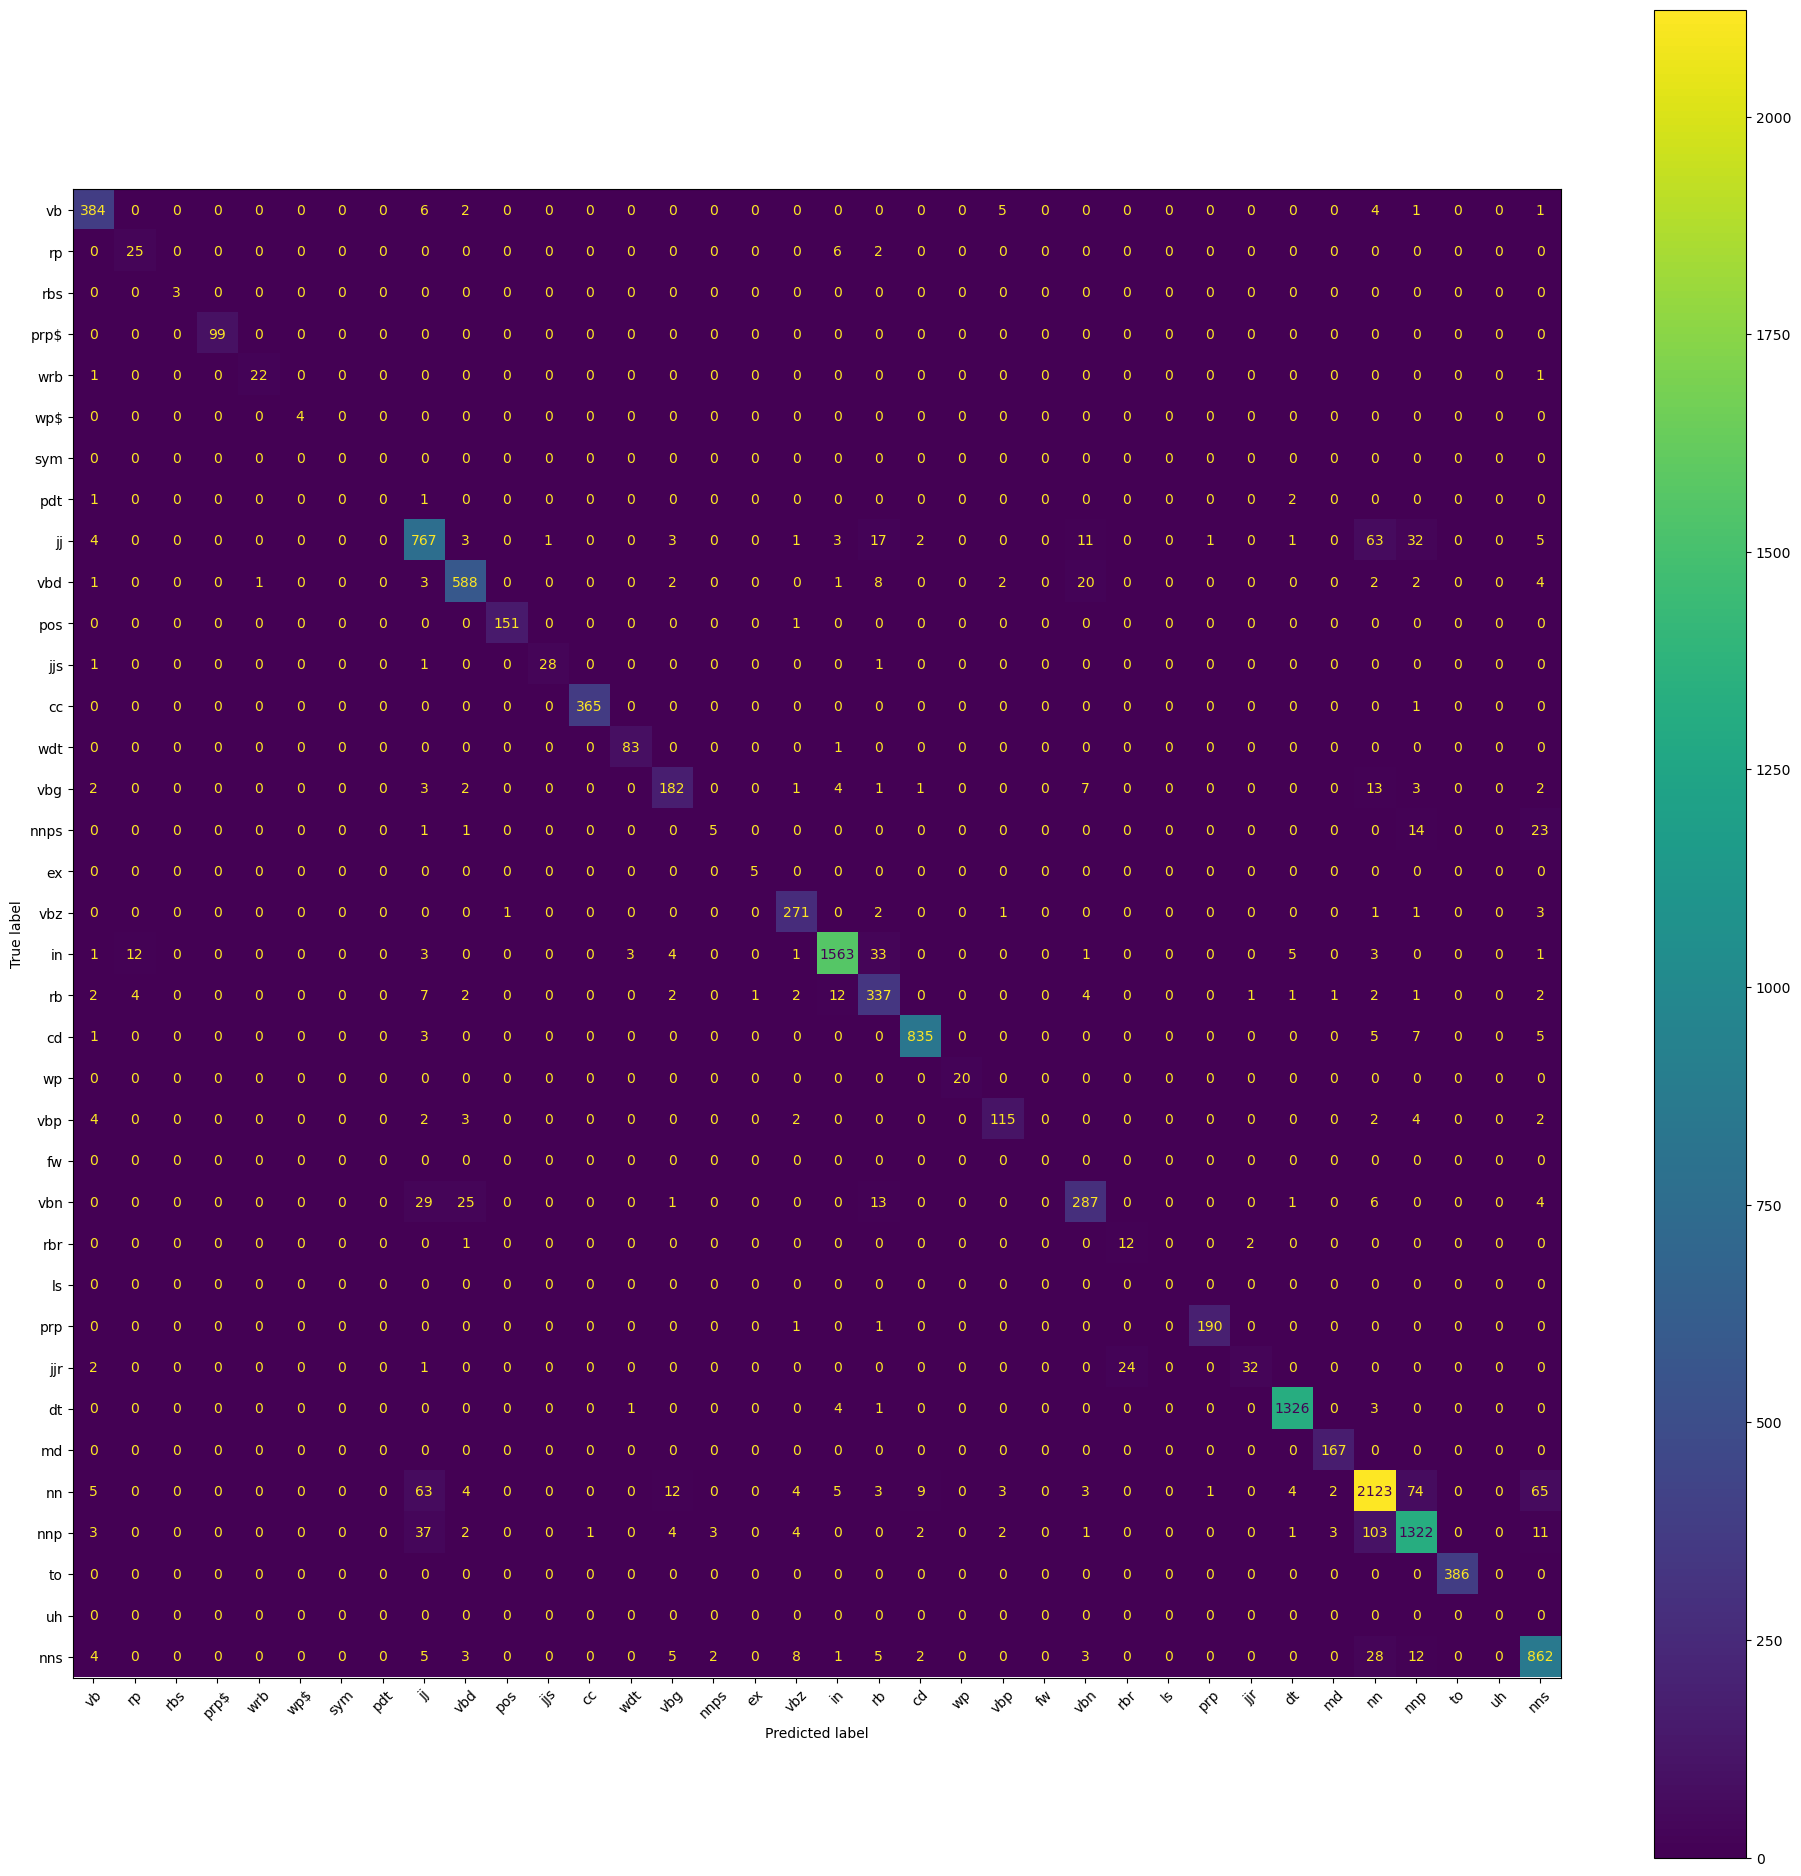

In [84]:
fig, ax = plt.subplots(figsize=(24, 24))
ConfusionMatrixDisplay(confusion_matrices['baseline'], display_labels=labels).plot(ax=ax, xticks_rotation=45)

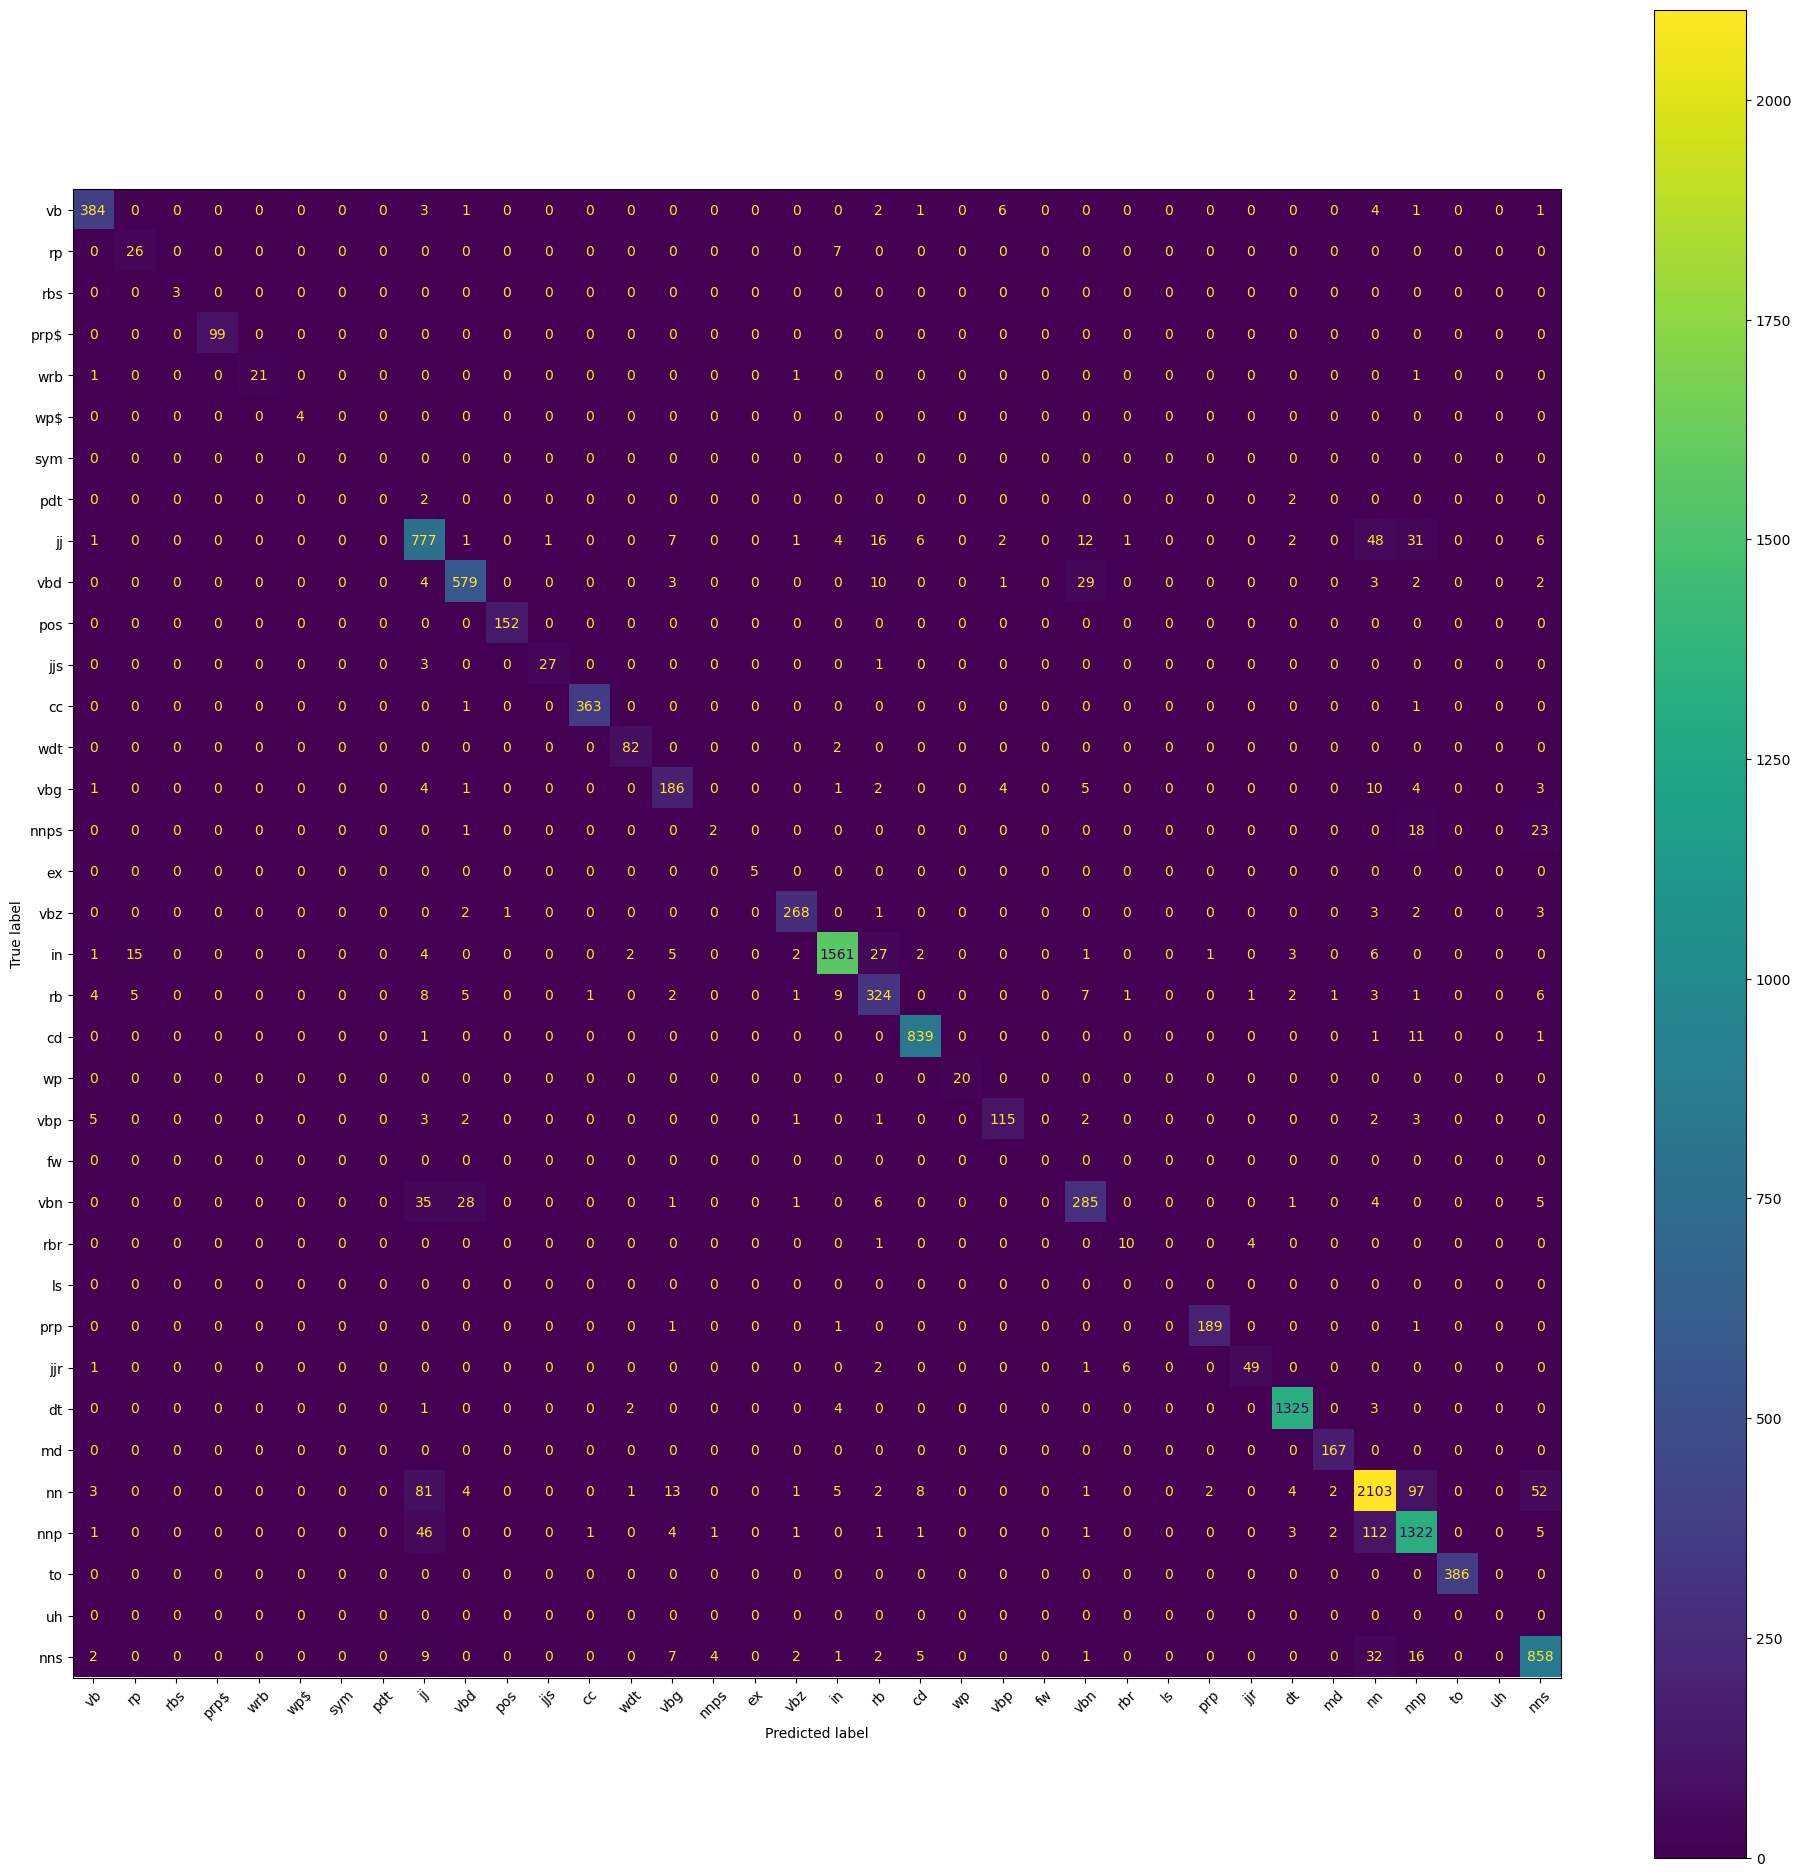

In [85]:
fig, ax = plt.subplots(figsize=(24, 24))
ConfusionMatrixDisplay(confusion_matrices['GRU'], display_labels=labels).plot(ax=ax, xticks_rotation=45)

### Precision and recall

In [86]:
prfsa = {}
for key, model in models.items():
    prfsa[key] = prfs(y_test_, y_test_pred[key], labels=labels)
    prfsa[key] = pd.DataFrame(prfsa[key], index=['precision', 'recall', 'f1', 'support'])

prfsa = pd.concat(prfsa).T
prfsa.index = labels
prfsa

baseline                                   GRU                      \
     precision    recall        f1 support precision    recall        f1   
vb    0.923077  0.952854  0.937729   403.0  0.950495  0.952854  0.951673   
rp    0.609756  0.757576  0.675676    33.0  0.565217  0.787879  0.658228   
rbs   1.000000  1.000000  1.000000     3.0  1.000000  1.000000  1.000000   
prp$  1.000000  1.000000  1.000000    99.0  1.000000  1.000000  1.000000   
wrb   0.956522  0.916667  0.936170    24.0  1.000000  0.875000  0.933333   
wp$   1.000000  1.000000  1.000000     4.0  1.000000  1.000000  1.000000   
sym   0.000000  0.000000  0.000000     0.0  0.000000  0.000000  0.000000   
pdt   0.000000  0.000000  0.000000     4.0  0.000000  0.000000  0.000000   
jj    0.821199  0.835512  0.828294   918.0  0.788832  0.846405  0.816605   
vbd   0.924528  0.927445  0.925984   634.0  0.926400  0.913249  0.919778   
pos   0.993421  0.993421  0.993421   152.0  0.987013  1.000000  0.993464   
jjs   0.965517  0.903226  0.933333    31.0  0.964286  0.870968  0.915254   
cc    0.997268  0.997268  0.997268   366.0  0.994521  0.991803  0.993160   
wdt   0.954023  0.988095  0.970760    84.0  0.942529  0.976190  0.959064   
vbg   0.846512  0.823529  0.834862   221.0  0.812227  0.841629  0.826667   
nnps  0.500000  0.113636  0.185185    44.0  0.285714  0.045455  0.078431   
ex    0.833333  1.000000  0.909091     5.0  1.000000  1.000000  1.000000   
vbz   0.915541  0.967857  0.940972   280.0  0.960573  0.957143  0.958855   
in    0.976875  0.958896  0.967802  1630.0  0.978683  0.957669  0.968062   
rb    0.794811  0.884514  0.837267   381.0  0.814070  0.850394  0.831836   
cd    0.972061  0.973193  0.972627   858.0  0.967705  0.977855  0.972754   
wp    1.000000  1.000000  1.000000    20.0  1.000000  1.000000  1.000000   
vbp   0.898438  0.858209  0.877863   134.0  0.898438  0.858209  0.877863   
fw    0.000000  0.000000  0.000000     0.0  0.000000  0.000000  0.000000   
vbn   0.851632  0.784153  0.816501   366.0  0.826087  0.778689  0.801688   
rbr   0.333333  0.800000  0.470588    15.0  0.555556  0.666667  0.606061   
ls    0.000000  0.000000  0.000000     0.0  0.000000  0.000000  0.000000   
prp   0.989583  0.989583  0.989583   192.0  0.984375  0.984375  0.984375   
jjr   0.914286  0.542373  0.680851    59.0  0.907407  0.830508  0.867257   
dt    0.988814  0.993258  0.991031  1335.0  0.987332  0.992509  0.989914   
md    0.965318  1.000000  0.982353   167.0  0.970930  1.000000  0.985251   
nn    0.898815  0.891268  0.895025  2382.0  0.899487  0.882872  0.891102   
nnp   0.893847  0.878989  0.886356  1504.0  0.871457  0.878989  0.875207   
to    1.000000  1.000000  1.000000   386.0  1.000000  1.000000  1.000000   
uh    0.000000  0.000000  0.000000     0.0  0.000000  0.000000  0.000000   
nns   0.868952  0.916047  0.891878   941.0  0.888199  0.911796  0.899843   

               twoLSTM                              twodense            \
     support precision    recall        f1 support precision    recall   
vb     403.0  0.943902  0.960298  0.952030   403.0  0.916865  0.957816   
rp      33.0  0.642857  0.818182  0.720000    33.0  0.533333  0.727273   
rbs      3.0  1.000000  0.333333  0.500000     3.0  1.000000  0.333333   
prp$    99.0  1.000000  1.000000  1.000000    99.0  1.000000  1.000000   
wrb     24.0  0.928571  0.541667  0.684211    24.0  0.941176  0.666667   
wp$      4.0  0.000000  0.000000  0.000000     4.0  1.000000  0.750000   
sym      0.0  0.000000  0.000000  0.000000     0.0  0.000000  0.000000   
pdt      4.0  0.000000  0.000000  0.000000     4.0  0.000000  0.000000   
jj     918.0  0.773845  0.857298  0.813437   918.0  0.785047  0.823529   
vbd    634.0  0.908527  0.924290  0.916341   634.0  0.916928  0.922713   
pos    152.0  0.993421  0.993421  0.993421   152.0  0.993464  1.000000   
jjs     31.0  0.800000  0.516129  0.627451    31.0  0.928571  0.838710   
cc     366.0  0.989130  0.994536  0.991826   366.0  0.994521  0.991803   
wdt    

In [87]:
px.bar(
        prfsa.xs('precision', level=1, axis=1).reset_index().melt(id_vars='index'),
        x='index',
        y='value',
        color='variable',
        barmode='group',
        title='Precision per model per class',
        labels={
            'index': 'class'
        }
    )

In [88]:
px.bar(
        prfsa.xs('recall', level=1, axis=1).reset_index().melt(id_vars='index'),
        x='index',
        y='value',
        color='variable',
        barmode='group',
        title='Recall per model per class',
        labels={
            'index': 'class'
        }
    )

In [89]:
px.bar(
        prfsa.xs('f1', level=1, axis=1).reset_index().melt(id_vars='index'),
        x='index',
        y='value',
        color='variable',
        barmode='group',
        title='F1 per model per class',
        labels={
            'index': 'class'
        },
    )

## Conclusions

This notebook clearly shows how the proposed neural models perform against the given task. While bigger models *should* give better results, the sheer amount of parameters **is not** indicative of model performance, the *baseline* model being the most performant while being the simplest among the proposed models. Architecture is actually more important than the amount of stacked layers.

The preprocessing pipeline, albeit short, is actually very important yet the use of GloVe embedding compensate for such absence. As a possible improvement, enriching the pipeline by handling common OOV cases such as dashed-words or numbers in the dataset *may* improve models' performance.

Most of the models errors involve nouns (single/plural, common/proper), adjectives and verbs (especially in past tense/past participle). These errors are relevant and can be addressed through a many different approaches, either based on feature engineering or more neural-oriented.

Overall, neural architectures are very effective with respect to the given problem even without attention mechanisms.